In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import tensorflow as tf
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/376_project/newcancerdata/'
oldpath = '/content/drive/MyDrive/376_project/cancerdata'
BATCH_SIZE = 64

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/376_project/labels.csv', dtype=str)
data.id = data.id + '.tif'
print(data.shape)
data.head


(10000, 3)


<bound method NDFrame.head of        index                                            id label
0         17  0003378267bd3d9964d701ff9e52ddce1b027e46.tif     0
1         49  000af35befdd9ab2e24fac80fb6508dfd1edd172.tif     1
2         66  0011a007b64a4a0f351ee4d7d00f237b1713b9bf.tif     0
3        160  002cf4e8faa1b238d67b3066fbeb382d128bc6e9.tif     0
4        183  0033eb6f1ae535166311e5837b006cba336e9200.tif     0
...      ...                                           ...   ...
9995  219929  ffe4b21fe0e2e13c677a0508aaa2717a0cf2ba08.tif     0
9996  219957  ffec122459ed1be2cb4a94009c115113a992813d.tif     0
9997  219958  ffec4a03e0a1b8d70e2bab767ac0f1803519e71a.tif     1
9998  219981  fff2b1244d1d9492ba0950f3221628add0e1cbd4.tif     0
9999  219986  fff3cf6f5992363edf773aa539a98679aad19180.tif     0

[10000 rows x 3 columns]>

In [4]:
train, val_test = train_test_split(data, train_size=0.8, random_state=376, shuffle=True)
val, test = train_test_split(val_test, train_size=0.5, random_state=376, shuffle=True)

print(f"Total number of examples in training set : {train.shape[0]}")
print(f"Total number of examples in validation set : {val.shape[0]}")
print(f"Total number of examples in test set : {test.shape[0]}")

Total number of examples in training set : 8000
Total number of examples in validation set : 1000
Total number of examples in test set : 1000


In [5]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   horizontal_flip=True,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   dtype=tf.float32)
val_datagen = ImageDataGenerator(rescale=1/255,
                                 dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1/255,
                                  dtype=tf.float32)

In [6]:
train_loader = train_datagen.flow_from_dataframe(dataframe=train,
                                                 directory=oldpath,
                                                 x_col='id',
                                                 y_col='label',
                                                 batch_size=BATCH_SIZE,
                                                 seed=376,
                                                 shuffle=True,
                                                 class_mode='categorical',
                                                 target_size=(96,96))

val_loader = val_datagen.flow_from_dataframe(dataframe=val,
                                             directory=oldpath,
                                             x_col='id',
                                             y_col='label',
                                             batch_size=BATCH_SIZE,
                                             seed=376,
                                             shuffle=True,
                                             class_mode='categorical',
                                             target_size=(96,96))

test_loader = test_datagen.flow_from_dataframe(dataframe=test,
                                               directory=oldpath,
                                               x_col='id',
                                               y_col='label',
                                               batch_size=BATCH_SIZE,
                                               seed=376,
                                               shuffle=False,
                                               class_mode='categorical',
                                               target_size=(96,96))

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [7]:
base_model = tf.keras.applications.vgg19.VGG19(
                                          input_shape=(96,96,3),
                                          include_top=False,
                                          weights='imagenet'
)
base_model.trainable = False

80150528/80134624 [==============================] - 2s 0us/step


In [8]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [9]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2,activation='softmax')
])


In [10]:
lr = 1e-4
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss ='categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC()],
)
model.build(input_shape = (None,96,96,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 8)                 36872     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 batch_normalization (BatchN  (None, 4)                1

In [11]:
TR_STEPS = len(train_loader)
VA_STEPS = len(val_loader)
epochs = 50
history = model.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    validation_data = val_loader,
    validation_steps = VA_STEPS,
    verbose = 1,
    epochs=epochs
)

Epoch 1/50
125/125 [==============================] - 5775s 46s/step - loss: 0.9359 - accuracy: 0.4857 - auc: 0.5080 - val_loss: 0.6692 - val_accuracy: 0.5600 - val_auc: 0.6443
Epoch 2/50
125/125 [==============================] - 35s 280ms/step - loss: 0.7551 - accuracy: 0.4789 - auc: 0.5027 - val_loss: 0.6868 - val_accuracy: 0.5270 - val_auc: 0.5687
Epoch 3/50
125/125 [==============================] - 34s 271ms/step - loss: 0.6843 - accuracy: 0.5865 - auc: 0.5994 - val_loss: 0.6849 - val_accuracy: 0.5990 - val_auc: 0.6028
Epoch 4/50
125/125 [==============================] - 34s 274ms/step - loss: 0.6785 - accuracy: 0.5950 - auc: 0.5980 - val_loss: 0.6777 - val_accuracy: 0.5990 - val_auc: 0.6105
Epoch 5/50
125/125 [==============================] - 34s 273ms/step - loss: 0.6773 - accuracy: 0.5961 - auc: 0.5970 - val_loss: 0.6775 - val_accuracy: 0.5990 - val_auc: 0.5998
Epoch 6/50
125/125 [==============================] - 35s 281ms/step - loss: 0.6777 - accuracy: 0.5960 - auc: 0.595

In [12]:
model.evaluate(test_loader)

16/16 [==============================] - 597s 40s/step - loss: 0.5963 - accuracy: 0.5850 - auc: 0.7562


[0.5962857604026794, 0.5849999785423279, 0.7561600208282471]

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


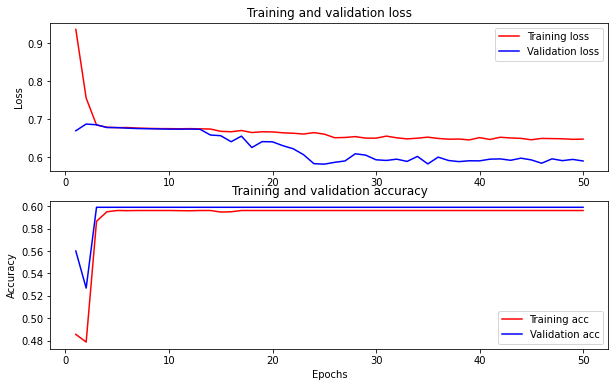

In [13]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [14]:
model.save('/content/drive/MyDrive/376_project/vgg19_no_crop/')
model = tf.keras.models.load_model('/content/drive/MyDrive/376_project/vgg19_no_crop/')
model.evaluate(test_loader)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/376_project/vgg19_no_crop/assets
16/16 [==============================] - 2s 119ms/step - loss: 0.5963 - accuracy: 0.5850 - auc: 0.7562


[0.5962857604026794, 0.5849999785423279, 0.7561600208282471]